In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import rasterio
import rasterio.mask
from rasterio.plot import show
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt
import seaborn as sns
from util_data_exploration import get_tile_images, reconvert_np_to_rasterio_dataset
from util_funcs import generate_flood_distribution_in_bins


In [2]:
scenario_path = 'data/Mflood1_grotekans/MaximaleWaterdiepteNederland_Kaart1.tif'
scenario_folders = [
    'data/Mflood1_grotekans/MaximaleWaterdiepteNederland_Kaart1.tif',
    'data/Mflood2_middelgrotekans/MaximaleWaterdiepteNederland_Kaart2.tif',
    'data/Mflood3_kleinekans/MaximaleWaterdiepteNederland_Kaart3.tif',
    'data/Mflood4_zeerkleinkans/MaximaleWaterdiepteNederland_Kaart4.tif',
    'data/Mflood5_extreemkleinekans/MaximaleWaterdiepteNederland_Kaart5.tif']
# with rasterio.open(scenario_path) as NL_map:
flood_maps = [rasterio.open(path) for path in scenario_folders]
flood_map = rasterio.open(scenario_path)
wijken = gpd.read_file('data/wijk_geometries.shp')
buurten = gpd.read_file('data/Rdam_buurten_shape.shp')
rdam_dsm_map = rasterio.open('data/rdam_topo_map.tif')
# Mask using shapefile
buurt_geometries = buurten.geometry.to_list()
df_flood_submaps = pd.read_pickle('data/df_flood_submaps.pkl.gz')
wijk_names = pd.read_pickle('data/wijk_names.pkl.gz')
rdam_land_bool_map = rasterio.open('data/rdam_topo_bool_map.tif')

## Merge DSM tiles into one image (one-time item, reactivate whenever necessary)
Procedure:
1. Retrieve all items from directory to be merged with
2. Open all items into list
3. Use rasterio.merge to save all into TIFF image for future use

In [3]:
# import rasterio.merge # ad hoc import
# # sanity check for tiff format
#
# path = 'data/DSMs/'
# dtm_files = [f for f in os.listdir(path) if '.tif' in f.lower()]
# # load into list for now
# dtm_list = [rasterio.open(f'{path}{name}') for name in dtm_files]
#
# mosaic, mosaic_trans = rasterio.merge.merge(dtm_list)
# f32_inf = 340282346638528859811704183484516925440.00000
# # mosaic[mosaic == f32_inf] = np.nan # ALERT: not necessary!
#
# fig, ax = plt.subplots()
# show(mosaic, transform=mosaic_trans,ax=ax)
# # plt.savefig('data/test_map.jpg',dpi=1000)
# # Save merged map as TIF image (for further reuse), one-time
# with rasterio.open('data/rdam_topo_map.tif',mode='w',count=1,
#                    width=mosaic.squeeze().shape[1],
#                    height=mosaic.squeeze().shape[0],
#                    crs=dtm_list[0].crs,
#                    transform=mosaic_trans,
#                    dtype=dtm_list[0].dtypes[0]) as dest:
#     dest.write(mosaic)

## Converting the Topo Map to boolean map for land/water


In [4]:
# ## CONVERSION OF TOPO MAP TO LAND/WATER BOOLEAN MAP, SCALED TO SAME FACTOR AS FLOOD MAP
# ## get rdam bool of land/water = 1/0 and save
# rdam_land_bool_map = rdam_dsm_map.read(1) < 3e38    # where 3e38 ~= numerical infinity
# downscale_factor = 5
# # np.newaxis creates an extra dummy axis for
# test_collapse = get_tile_images(rdam_land_bool_map[:,:,np.newaxis],
#                                 width=downscale_factor, height=downscale_factor)
#
# ## AGGREGATE TO NEW RESOLUTION VIA WATER-BOOL METHOD
# # since water/land is simply as 1/0,
# test_collapse2 = np.sum(test_collapse,axis=(2,3)).squeeze()
# # need to filter out again into binary
# test_collapse3 = (test_collapse2 > ((downscale_factor * downscale_factor) //2) + 1).astype(int)
#
# sanity_check = True
# if sanity_check:
#     # Sanity check: to see if the delta affects the accuracy of downsampling
#     fitting = []
#     binary_bound = range(0,25,1)
#     for bound in binary_bound:
#         fitting.append(np.sum(test_collapse2 > bound))
#
#     deltas = (fitting-fitting[0])/(test_collapse2.shape[0]*test_collapse2.shape[1])
#     plt.scatter(x=binary_bound, y=deltas)
#
#     """ The plot below shows x = 'bound limit for accepting the cell as terrain', and y = 'percentage delta of terrain that would increase if the bound increases'.
#
#     With increasing bound threshold, between 0 <= bound <= 15 the percentage difference is on the order of 0 - 4% (using bound = 0 as a base case). Using the midpoint (25/2 = 12.5) makes for an acceptable bound for aggregation.
#     """

In [5]:
# # CORRECT AFFINE TRANSFORM AND RECREATE AS DATASET AGAIN
# host_map = rdam_dsm_map # original coordinate bounds
# # generate new affine transform
# test_collapse3_transform = rasterio.transform.from_bounds(
#     west=host_map.bounds.left,
#     south=host_map.bounds.bottom,
#     east=host_map.bounds.right,
#     north=host_map.bounds.top,
#     width=test_collapse3.shape[1],
#     height=test_collapse3.shape[0]
# )
# # recreate Rasterio Dataset object
# test_collapse4 = reconvert_np_to_rasterio_dataset(test_collapse3, transform=test_collapse3_transform)

In [6]:
# # save rasterio dataset object
# with rasterio.open('data/rdam_topo_bool_map.tif', mode='w', count=1,
#                    width=test_collapse3.shape[1],
#                    height=test_collapse3.shape[0],
#                    crs=rdam_dsm_map.crs,
#                    transform=test_collapse3_transform,
#                    dtype=test_collapse3.dtype) as dest:
#     dest.write(test_collapse3[np.newaxis])

In [7]:
# # current objective: plot the new map over the geo maps to see if they make sense
# fig, ax = plt.subplots()
# show(test_collapse4,ax=ax,cmap='GnBu')
# buurten.plot(ax=ax,
#              **{'alpha':0.6,
#                      'edgecolor':'w',
#                      'facecolor':'lime'
#                      })
# plt.axis('off')
# # fig.savefig('data/test_map.jpg',dpi=1000)

In [8]:
# CUT OUT ONLY RDAM SECTOR AND SAVE
# rdam_map,rdam_transform = rasterio.mask.mask(nl_map, rdam_geometries,crop=True)
rdam_floodmap, rdam_floodtransform = rasterio.mask.mask(flood_map, buurt_geometries, crop=True)

In [9]:
# Create container of cut flood maps per wijk, per flood map.

# need to create labels (lowercase, spaces converted to hyphen)
wijk_names = wijken.WK_NAAM.str.replace(' ', '-').str.lower()
wijk_geometries = wijken.geometry

# create masks for unflooded and flooded tiles

wijk_scenario_labels = []
# baseline_submaps = []
flood_submaps = []

# knockout the flood maps with area geo outline
for idx, wijk in enumerate(wijk_names):
    geo = wijk_geometries[idx]
    wijk_scenario_labels.extend([(wijk, number+1) for number, _ in enumerate(flood_maps)])
    flood_submaps.extend([rasterio.mask.mask(f_m, [geo], crop=True, nodata=np.nan) for f_m in flood_maps])

# put together the items into nice dict
# for idx, label in enumerate(wijk_scenario_labels):
# extracc
w_names, w_scenarios = zip(*wijk_scenario_labels)
w_submaps, w_submap_trans = zip(*flood_submaps)
w_indices = ['.'.join([str(number), wijk]) for wijk, number in wijk_scenario_labels]

# create dict for column form, and then create dataframe
df_flood_submaps = pd.DataFrame.from_dict(
    {'index': w_indices,
      'wijk': w_names,
      'scenario': w_scenarios,
      'submap': w_submaps,
      'transform': w_submap_trans}, orient='columns').set_index('index')


In [10]:
# COMPRESS FLOOD SUBMAPS TO PICKLE
df_flood_submaps.to_pickle('data/df_flood_submaps.pkl.gz')
wijk_names.to_pickle('data/wijk_names.pkl.gz')

In [11]:
# Infer water to non-water tiles

# create masks for different wijks:
# wijk_raw_masks = [rasterio.mask.mask(rdam_dsm_map, [w], crop=True, nodata=np.nan) for w in wijk_geometries]

# correct flood maps with inland bodies of water
dict_wijk_landmasks = dict(zip(
    wijk_names,
    [rasterio.mask.mask(rdam_land_bool_map, [g], crop=True, nodata=0) for g in wijk_geometries]
))
# includes np.ndarray and affine transform object

# NOTE: 0 set for non-land values, including water and out-of-bounds territory

In [12]:

# assign identification to land area maps
# retrieve name for land knockout, use submap
# (assumption that the submap is compatible with the transform)
# check if all submaps match the landmask (sanity check)

# look at column
# check shape match
# update floodmap item
# test_submap = df_flood_submaps.loc['2.delfshaven','submap'].squeeze()
# test_landmask = dict_wijk_landmasks['delfshaven'][0].squeeze().astype(bool) # force conversion to bool needed


# using np.where preserves the 2d order instead of a bool mask
# test_output = np.where(test_landmask, test_submap, test_submap.min())

# iterate over rows
# use the name of the area for retrieval input to dict_wijk_landmasks
# use numpy vectorize

In [13]:
# get the distribution of flooded and non-flooded tiles per area
col_pct_flood = []
col_depth_distribution = []
col_flood_tiles = []
col_land_tiles = []
col_new_submaps = []
for submap_idx in df_flood_submaps.index:
    submap = df_flood_submaps.loc[submap_idx,'submap'].squeeze()
    landmask = dict_wijk_landmasks[df_flood_submaps.loc[submap_idx,'wijk']][0].squeeze().astype(bool)
    corrected_submap = np.where(landmask, submap, submap.min())
    # total area in arbitrary units
    land_count = landmask.sum()
    flood_distr = corrected_submap[corrected_submap > -9999.]
    flood_count = (corrected_submap > -9999.).sum()
    # print(land_count,flood_count)
    col_depth_distribution.append(flood_distr)
    col_pct_flood.append(flood_count/land_count)
    col_land_tiles.append(land_count)
    col_flood_tiles.append(flood_count)
    col_new_submaps.append(corrected_submap)

#
df_flood_submaps['land_tiles'] = col_land_tiles
df_flood_submaps['flood_tiles'] = col_flood_tiles
df_flood_submaps['flood_depths'] = col_depth_distribution
df_flood_submaps['flood_pct_landmass'] = col_pct_flood
df_flood_submaps.submap = col_new_submaps
# Assign number of tiles without flood to a new column
df_flood_submaps['safe_tiles'] = df_flood_submaps.land_tiles - df_flood_submaps.flood_tiles



In [14]:
# This section focuses on the binning of the flood distribution data for the flood scenarios, per area (wijk/buurt).

# digitise to bins of 0.5
bins_resolution = 0.5   # metres
bins_max = 5   # in metres, but cutoff point is specified to be 5 m (from alessandro's code)
bins_total = np.arange(bins_resolution, bins_max + bins_resolution, bins_resolution)

flood_distributions_binned = []
# use the util function from util_func.py
debug_print = False
for idx, row in df_flood_submaps.iterrows():
    depth_arr = row.flood_depths
    binned, outliers, eliminated =  generate_flood_distribution_in_bins(input_arr=depth_arr,
                                                  bins=bins_total,outlier_ceil=8.,exclude_outliers=False)
    # the exclude_outliers arg was included because some low-lying areas have quite severe flooding, but within 'reasonable' ranges (see Rozenburg scenario 4)
    # print wijk and scenario for outliers
    print('outliers (acceptable) / outliers (eliminated) / flood / total:') if idx == 0 else None
    if len(outliers) > 0 and debug_print:
        print(f' {len(outliers)} / {len(eliminated)} / {len(depth_arr)} / {row.land_tiles} ({row.wijk}, {row.scenario})')
    # insert extra no-flood bin at the front!
    binned = np.insert(binned,0,row.safe_tiles)
    # write to list first, assign to df later
    flood_distributions_binned.append(binned)

# Assign binned distributions to dataframe
df_flood_submaps['flood_distribution_bins'] = flood_distributions_binned


# what's next? need to convert that into function
# need to merge together the flood parts and non-flood parts
# could include that in a nice input for np.choice
# maybe an overarching function for the maximum bins?
# need to get the remainder of non-flooded tiles for generation
# need to create agent flood exposure generator, scaled with number of agents

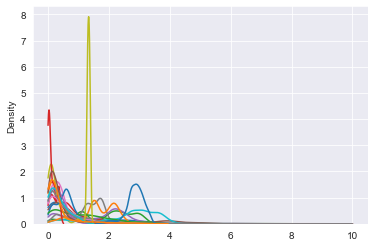

In [15]:
##  want to plot the distribution of flood effects
# test with one scenario?
subset = df_flood_submaps[df_flood_submaps.scenario == 4]
# convert flood depths into long table

fig, ax = plt.subplots()
for name, row in subset.iterrows():
    depths = row.loc['flood_depths']
    # print(name, max(depths), min(depths))
    sns.kdeplot(data=row, x=depths, ax=ax, clip=(0,10))
fig.savefig('data_model_inputs/kde_s2_rdam.jpg',dpi=1000)
# from the graph, most flooding occur before 4m high for scenario 2
# number of houses must match the number of spaces...? Does not account for highrise/high-density housing...

# how to generate which houses are damaged?
# call all houses to apply floods and damages (latter could be precalculated?)
# use dict ledger to keep track of damaages
# houses are fixed the next step? but history of flooding remains? Households take up a certain debt to repair? Perhaps no inclusion of repairing yet
# logic of house value degradation though
# artificial ceiling to 6/7 m since the limit is also as such?

In [19]:
# generate the zeroth scenario and shift the scenario mode
# NOTE: many things are hardcoded here!

z_areas = df_flood_submaps.wijk.unique()
z_new_rows: dict = {}
z_dict_submaps: dict = dict_wijk_landmasks.copy()

for key, tup in z_dict_submaps.items():
    z_submap, z_transform = tup # split them up again
    z_land_tiles = z_submap.sum()
    z_submap = np.where(z_submap.astype(bool),0, np.nan).astype('float32') # ensure that cast to the same dtype as the others, but
    # insert into index dict
    z_new_rows[f"0.{key}"] = [key,0, z_submap, z_transform, z_land_tiles, 0, [], 0., z_land_tiles, [z_land_tiles] + [0,0,0,0,0,0,0,0,0]]

# convert into pd.Dataframe
z_df = pd.DataFrame.from_dict(z_new_rows, orient='index', columns=df_flood_submaps.columns)

z_reference = df_flood_submaps[df_flood_submaps.scenario == 3].copy()

# sanity check: check the number of land tiles
print(f"sanity check if original land tiles are the same with the df_flood_submaps: {z_df.land_tiles.to_list() == z_reference.land_tiles.to_list()}")
# need to cast the columns into the same dtype
for k, v in list(zip(df_flood_submaps.columns, df_flood_submaps.dtypes)):
    z_df[k] = z_df[k].astype(v)
# concatenate into df_flood_submaps
df_flood_submaps = pd.concat([df_flood_submaps, z_df], axis=0).sort_index()


sanity check if original land tiles are the same with the df_flood_submaps: True


In [20]:
# save the df into pickle
overwrite = False
if overwrite:
    df_flood_submaps.to_pickle('data_model_inputs/flood_scenarios_per_wijk.pickletable')

In [18]:
#